# Load data

In [1]:
import pandas as pd
from constants import NULLABLE_MEASURES
from utils.class_patient import Patients

patients = Patients.loadPatients()
patients.fillMissingMeasureValue(NULLABLE_MEASURES, 0)

# Remove missing data

## Remove features with more than 20% missing

In [2]:
# remove measures with less than 80% of data

measures = patients.getMeasures()

for measure, count in measures.items():
    if count < len(patients) * 80 / 100:
        patients.removeMeasures([measure])
        print(measure, count)

pco2 917
ph 954
po2 917
albumin 406
hba1c 326
lymphocyte 446
height 415
urine-ketone 294
crp 19


## Remove patients with more than 20% missing features

In [3]:
patients.removePatientByMissingFeatures()
len(patients)

1206

## Display insight

In [4]:
# dfData = patients.getMeasuresBetween(pd.Timedelta(hours=-6), pd.Timedelta(hours=24), "first")

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(patients.getMeasures())

Counter({'age': 1206,
         'chronic_pulmonary_disease': 1206,
         'ckd_stage': 1206,
         'congestive_heart_failure': 1206,
         'dka_type': 1206,
         'gender': 1206,
         'history_aci': 1206,
         'history_ami': 1206,
         'hypertension': 1206,
         'liver_disease': 1206,
         'macroangiopathy': 1206,
         'malignant_cancer': 1206,
         'mechanical_ventilation': 1206,
         'microangiopathy': 1206,
         'oasis': 1206,
         'preiculos': 1206,
         'race': 1206,
         'saps2': 1206,
         'sofa': 1206,
         'use_NaHCO3': 1206,
         'uti': 1206,
         'ag': 1205,
         'bg': 1205,
         'bicarbonate': 1205,
         'bun': 1205,
         'chloride': 1205,
         'egfr': 1205,
         'hr': 1205,
         'potassium': 1205,
         'scr': 1205,
         'sodium': 1205,
         'dbp': 1204,
         'gcs': 1204,
         'gcs_unable': 1204,
         'rr': 1204,
         'sbp': 1204,
         'calci

In [5]:
akdCount = sum([p.akdPositive for p in patients.patientList])

akdCount / len(patients)

0.39303482587064675

# Machine learning

In [6]:
from constants import CATEGORICAL_MEASURES


idColumns = ["subject_id", "hadm_id", "stay_id"]
categoryColumns = CATEGORICAL_MEASURES
labelColumn = "akd"

## Split train-test

In [7]:
splitedPatients = patients.split(5, 27)


def trainTest():
    for i in range(splitedPatients.__len__()):
        testPatients = splitedPatients[i]

        trainPatientsList = splitedPatients[:i] + splitedPatients[i + 1 :]
        trainPatients = Patients(patients=[])
        for trainPatientsElem in trainPatientsList:
            trainPatients += trainPatientsElem

        yield trainPatients, testPatients


def trainValTest():
    for i in range(splitedPatients.__len__()):
        testPatients = splitedPatients[i]

        trainPatientsList = splitedPatients[:i] + splitedPatients[i + 1 :]
        trainPatients = Patients(patients=[])
        for trainPatientsElem in trainPatientsList:
            trainPatients += trainPatientsElem

        *trainPatients, valPatients = trainPatients.split(5, 27)
        tmpPatients = Patients(patients=[])
        for trainPatientsElem in trainPatients:
            tmpPatients += trainPatientsElem
        trainPatients = tmpPatients

        yield trainPatients, valPatients, testPatients

## Define model

In [36]:
from gplearn.genetic import SymbolicClassifier

how = "last"


def createModel():
    m = SymbolicClassifier(
        generations=30, 
        init_depth=(2, 6),
        p_crossover=0.7,
        p_hoist_mutation=0.05,
        p_point_mutation=0.05, 
        p_subtree_mutation=0.1,
        parsimony_coefficient=0.001,
        population_size=500,
        stopping_criteria=0.01,
        tournament_size=10,
        function_set=("add", "sub", "mul", "div", "sqrt", "log", "abs", "neg", "inv"),
    )
    return m

## Without validate

### Without fill missing data

In [37]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from utils.prepare_data import normalizeData


accuracy_score_list = []
precision_score_list = []
recall_score_list = []
auc_score_list = []
for trainPatients, testPatients in trainTest():
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, _ = normalizeData(dfTrain, dfTest)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    X_train = X_train.fillna(0)
    X_test = X_test.fillna(0)

    model = createModel()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

    accuracy_score_list.append(accuracy_score(y_test, y_pred))
    precision_score_list.append(precision_score(y_test, y_pred))
    recall_score_list.append(recall_score(y_test, y_pred))
    auc_score_list.append(roc_auc_score(y_test, y_pred_proba))

In [39]:

print(f"Average AUC: {np.mean(auc_score_list)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list)}")
print(f"Average Precision: {np.mean(precision_score_list)}")
print(f"Average Recall: {np.mean(recall_score_list)}")

Average AUC: 0.7381776661331056
Average Accuracy: 0.6840951956380097
Average Precision: 0.635455890646942
Average Recall: 0.5340425531914894


### Fill missing with knn

In [38]:
from sklearn.metrics import roc_auc_score
from utils.prepare_data import normalizeAndFillData


accuracy_score_list_knn = []
precision_score_list_knn = []
recall_score_list_knn = []
auc_score_list_knn = []
for trainPatients, testPatients in trainTest():
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, _ = normalizeAndFillData(dfTrain, dfTest)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]
    
    # existing nullable time-based features that is out of the time range
    X_train = X_train.fillna(0)
    X_test = X_test.fillna(0)

    model = createModel()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

    accuracy_score_list_knn.append(accuracy_score(y_test, y_pred))
    precision_score_list_knn.append(precision_score(y_test, y_pred))
    recall_score_list_knn.append(recall_score(y_test, y_pred))
    auc_score_list_knn.append(roc_auc_score(y_test, y_pred_proba))

In [40]:

print(f"Average AUC: {np.mean(auc_score_list_knn)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list_knn)}")
print(f"Average Precision: {np.mean(precision_score_list_knn)}")
print(f"Average Recall: {np.mean(recall_score_list_knn)}")

Average AUC: 0.7552967295617566
Average Accuracy: 0.7048077912280101
Average Precision: 0.6476866543278648
Average Recall: 0.5529227323628219


In [24]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from utils.prepare_data import normalizeData


param_grid = {
    "population_size": [500],
    "generations": [30],
    "tournament_size": [10],
    "stopping_criteria": [0.0],
    "init_depth": [(2, 6)],
    "p_crossover": [0.7],
    "p_subtree_mutation": [0.1],
    "p_hoist_mutation": [0.05],
    "p_point_mutation": [0.05],
    "parsimony_coefficient": [0.001],
}

est_gp = SymbolicClassifier(
    function_set=("add", "sub", "mul", "div"),
    const_range=(-1.0, 1.0),
    init_method="half and half",
    n_jobs=3,
    verbose=1,
    random_state=42,
)

scorer = make_scorer(roc_auc_score)

gridSearch = GridSearchCV(
    est_gp, param_grid, scoring=scorer, cv=5, verbose=1, n_jobs=3
)

dfAll = patients.getMeasuresBetween(
    pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
)
dfAll = dfAll.drop(columns=idColumns)
dfAll, _, _ = normalizeData(dfAll, dfAll)
X_all = dfAll.drop(columns=[labelColumn])
y_all = dfAll[labelColumn]

X_all = X_all.fillna(0)

gridSearch.fit(X_all, y_all)

print("Params", gridSearch.best_params_)
print("Scores", gridSearch.best_score_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    21.79          1.19347        3           0.6162              N/A      5.06s
   0    21.79          1.19459        3         0.605566              N/A      5.36s
   0    21.79          1.18821     

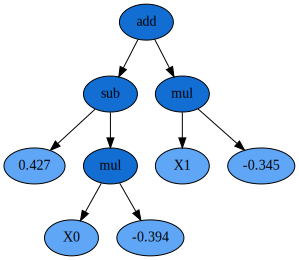

In [50]:
import graphviz 

dot_data = model._program.export_graphviz()
graph = graphviz.Source(dot_data)
graph

In [55]:
for i, (trainPatients, testPatients) in enumerate(trainTest()):
    if i != 4:
        continue
    
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, _ = normalizeAndFillData(dfTrain, dfTest)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    # existing nullable time-based features that is out of the time range
    X_train = X_train.fillna(0)
    X_test = X_test.fillna(0)

    model = createModel()
    model.fit(X_train, y_train)

    break

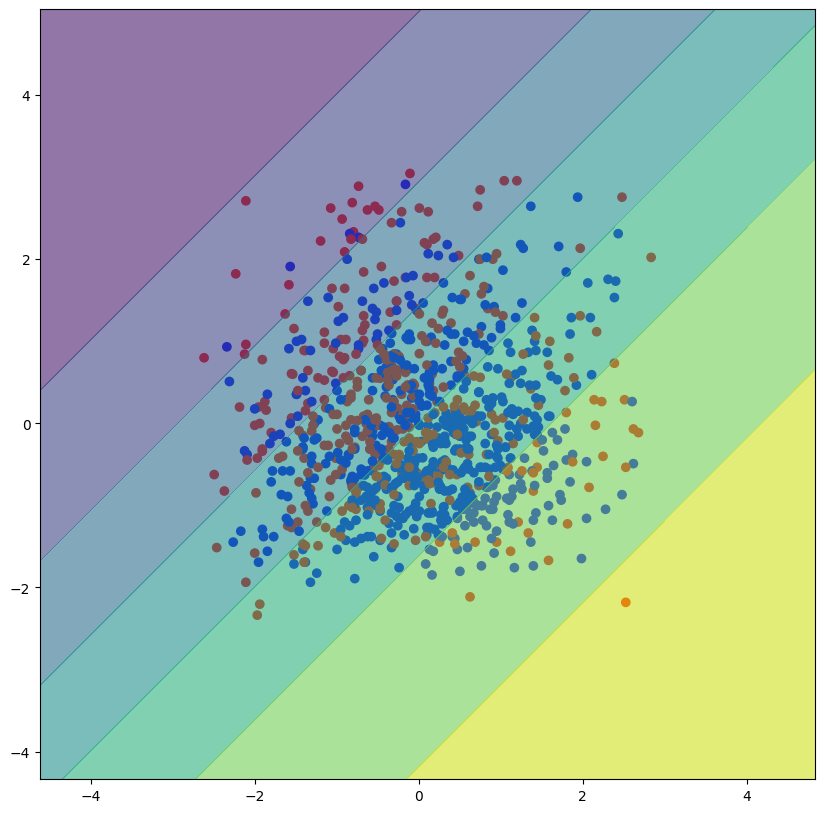

In [59]:
from sklearn.inspection import DecisionBoundaryDisplay
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap


classifier = model



# PLOTTING
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", "#0000FF"])

# Plot the training points
vfunc = np.vectorize(lambda x: np.where(classifier.classes_ == x)[0])
y_train_index = vfunc(y_train)
y_train_index = y_train_index == 0

npX = X_train[["rbc", "wbc"]]
npX = npX.to_numpy()

ax.scatter(npX[:, 0], npX[:, 1], c=y_train_index, cmap=cm_bright)

classifier.fit(npX[:, 0:2], y_train_index)

DecisionBoundaryDisplay.from_estimator(
    classifier,
    npX[:, 0:2],
    alpha=0.6,
    ax=ax,
    eps=2.0,
    grid_resolution=25,
    response_method="predict_proba",
)

## With validate

### Without fill missing data

In [ ]:
from utils.prepare_data import normalizeData


accuracy_score_list_val = []
precision_score_list_val = []
recall_score_list_val = []
auc_score_list_val = []
for trainPatients, valPatients, testPatients in trainValTest():
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfVal = valPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfVal = dfVal.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, dfVal = normalizeData(dfTrain, dfTest, dfVal)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_val = dfVal.drop(columns=[labelColumn]) # type: ignore
    y_val = dfVal[labelColumn] # type: ignore

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createModel()
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

    accuracy_score_list_val.append(accuracy_score(y_test, y_pred))
    precision_score_list_val.append(precision_score(y_test, y_pred))
    recall_score_list_val.append(recall_score(y_test, y_pred))
    auc_score_list_val.append(roc_auc_score(y_test, y_pred_proba))

[0]	validation_0-logloss:0.62658
[1]	validation_0-logloss:0.61787
[2]	validation_0-logloss:0.60825
[3]	validation_0-logloss:0.61854
[4]	validation_0-logloss:0.62367
[5]	validation_0-logloss:0.62644
[6]	validation_0-logloss:0.63329
[7]	validation_0-logloss:0.64227
[8]	validation_0-logloss:0.65172
[9]	validation_0-logloss:0.64617
[10]	validation_0-logloss:0.65757
[11]	validation_0-logloss:0.65470
[12]	validation_0-logloss:0.65518
[13]	validation_0-logloss:0.65870
[14]	validation_0-logloss:0.66935
[15]	validation_0-logloss:0.67224
[16]	validation_0-logloss:0.68179
[17]	validation_0-logloss:0.69492
[18]	validation_0-logloss:0.70978
[19]	validation_0-logloss:0.70878
[20]	validation_0-logloss:0.70907
[21]	validation_0-logloss:0.71880
[22]	validation_0-logloss:0.72458
[23]	validation_0-logloss:0.72276
[24]	validation_0-logloss:0.73306
[25]	validation_0-logloss:0.73529
[26]	validation_0-logloss:0.74307
[27]	validation_0-logloss:0.74915
[28]	validation_0-logloss:0.75065
[29]	validation_0-loglos

In [ ]:


print(f"Average AUC: {np.mean(auc_score_list_val)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list_val)}")
print(f"Average Precision: {np.mean(precision_score_list_val)}")
print(f"Average Recall: {np.mean(recall_score_list_val)}")

Average AUC: 0.7702842661938603
Average Accuracy: 0.7137992524261858
Average Precision: 0.6570206096718026
Average Recall: 0.5694517543859648


### Fill missing with knn

In [ ]:
from sklearn.metrics import roc_auc_score
from utils.prepare_data import normalizeAndFillData


accuracy_score_list_val_knn = []
precision_score_list_val_knn = []
recall_score_list_val_knn = []
auc_score_list_val_knn = []
metric_dic_list_val_knn = []
for trainPatients, valPatients, testPatients in trainValTest():
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfVal = valPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfVal = dfVal.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, dfVal = normalizeAndFillData(dfTrain, dfTest, dfVal)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_val = dfVal.drop(columns=[labelColumn])  # type: ignore
    y_val = dfVal[labelColumn]  # type: ignore

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createModel()
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

    accuracy_score_list_val_knn.append(accuracy_score(y_test, y_pred))
    precision_score_list_val_knn.append(precision_score(y_test, y_pred))
    recall_score_list_val_knn.append(recall_score(y_test, y_pred))
    auc_score_list_val_knn.append(roc_auc_score(y_test, y_pred_proba))

[0]	validation_0-logloss:0.62379
[1]	validation_0-logloss:0.61905
[2]	validation_0-logloss:0.61721
[3]	validation_0-logloss:0.61468
[4]	validation_0-logloss:0.61063
[5]	validation_0-logloss:0.61218
[6]	validation_0-logloss:0.62720
[7]	validation_0-logloss:0.63811
[8]	validation_0-logloss:0.63752
[9]	validation_0-logloss:0.64703
[10]	validation_0-logloss:0.65361
[11]	validation_0-logloss:0.66004
[12]	validation_0-logloss:0.67004
[13]	validation_0-logloss:0.67440
[14]	validation_0-logloss:0.68253
[15]	validation_0-logloss:0.68798
[16]	validation_0-logloss:0.69345
[17]	validation_0-logloss:0.69497
[18]	validation_0-logloss:0.69686
[19]	validation_0-logloss:0.69903
[20]	validation_0-logloss:0.71029
[21]	validation_0-logloss:0.72110
[22]	validation_0-logloss:0.72845
[23]	validation_0-logloss:0.73714
[24]	validation_0-logloss:0.73457
[25]	validation_0-logloss:0.73616
[26]	validation_0-logloss:0.74262
[27]	validation_0-logloss:0.74551
[28]	validation_0-logloss:0.75446
[29]	validation_0-loglos

In [ ]:
print(f"Average AUC: {np.mean(auc_score_list_val_knn)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list_val_knn)}")
print(f"Average Precision: {np.mean(precision_score_list_val_knn)}")
print(f"Average Recall: {np.mean(recall_score_list_val_knn)}")

Average AUC: 0.7737709795525997
Average Accuracy: 0.7204279688625219
Average Precision: 0.6720220650045212
Average Recall: 0.5694956140350877
